In [1]:
import requests
import os
import json
from dotenv import load_dotenv
load_dotenv()

# --- 1. FRED API 설정 정보 ---

# 데이터 시리즈 ID (미국 금리 핵심 지표)
SERIES_IDS = {
    "기준금리 (FEDFUNDS)": "FEDFUNDS",  # 실효 연방기금 금리 (단기 정책 금리)
    "10년물 국채 수익률 (DGS10)": "DGS10",  # 장기 시장 금리 (시장 벤치마크)
}

# 요청 파라미터 설정
# - observation_start: 데이터 시작 날짜 (YYYY-MM-DD)
# - file_type: 응답 데이터 형식 (json이 분석에 용이)
# - frequency: 데이터 주기 (d: 일별, m: 월별, q: 분기별, a: 연간)
REQUEST_PARAMS = {
    # 💡 2015년 10월 1일부터 요청 (약 10년치)
    "observation_start": "2015-10-01", 
    "file_type": "json",
    "api_key" : os.getenv("FRED_API_KEY"), # 환경 변수에서 FRED_API_KEY를 가져와 설정
    "frequency": "m"  # 월별 데이터 요청
}

def get_fred_data(series_id, series_name):
    """
    FRED API에서 특정 시리즈 ID의 데이터를 가져오는 함수
    """
    # FRED API의 기본 URL
    base_url = "https://api.stlouisfed.org/fred/series/observations"
    
    # 시리즈 ID 추가
    params = REQUEST_PARAMS.copy()
    params["series_id"] = series_id

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status() # HTTP 오류가 발생하면 예외 발생
        
        data = response.json()
        
        print(f"\n--- {series_name} 데이터 ({series_id}) ---")
        
        # 데이터가 있는지 확인
        observations = data.get("observations")
        if not observations:
            print("데이터를 찾을 수 없거나 API 키가 잘못되었습니다.")
            return

        # 💡 최근 12개월 (1년치) 데이터만 출력합니다. (API는 10년치를 가져옴)
        print("최근 12개월 데이터 출력:")
        for obs in observations[-12:]:
            print(f"날짜: {obs['date']}, 금리: {obs['value']}%")

    except requests.exceptions.RequestException as e:
        print(f"API 요청 중 오류 발생: {e}")
    except json.JSONDecodeError:
        print("JSON 디코딩 오류: 응답 형식이 잘못되었습니다.")

# --- 메인 실행 ---
if __name__ == "__main__":
    for name, series_id in SERIES_IDS.items():
        get_fred_data(series_id, name)


--- 기준금리 (FEDFUNDS) 데이터 (FEDFUNDS) ---
최근 12개월 데이터 출력:
날짜: 2024-10-01, 금리: 4.83%
날짜: 2024-11-01, 금리: 4.64%
날짜: 2024-12-01, 금리: 4.48%
날짜: 2025-01-01, 금리: 4.33%
날짜: 2025-02-01, 금리: 4.33%
날짜: 2025-03-01, 금리: 4.33%
날짜: 2025-04-01, 금리: 4.33%
날짜: 2025-05-01, 금리: 4.33%
날짜: 2025-06-01, 금리: 4.33%
날짜: 2025-07-01, 금리: 4.33%
날짜: 2025-08-01, 금리: 4.33%
날짜: 2025-09-01, 금리: 4.22%

--- 10년물 국채 수익률 (DGS10) 데이터 (DGS10) ---
최근 12개월 데이터 출력:
날짜: 2024-11-01, 금리: 4.36%
날짜: 2024-12-01, 금리: 4.39%
날짜: 2025-01-01, 금리: 4.63%
날짜: 2025-02-01, 금리: 4.45%
날짜: 2025-03-01, 금리: 4.28%
날짜: 2025-04-01, 금리: 4.28%
날짜: 2025-05-01, 금리: 4.42%
날짜: 2025-06-01, 금리: 4.38%
날짜: 2025-07-01, 금리: 4.39%
날짜: 2025-08-01, 금리: 4.26%
날짜: 2025-09-01, 금리: 4.12%
날짜: 2025-10-01, 금리: .%


In [10]:
from dotenv import load_dotenv
import os

load_dotenv() # 모든 환경 변수를 한 번에 로드

# FRED API 키 사용
FRED_API_KEY = os.getenv("FRED_API_KEY")

# ECOS API 키 사용
ECOS_API_KEY = os.getenv("ECOS_API_KEY") 

print(f"FRED 키 로드 완료: {FRED_API_KEY is not None}")
print(f"ECOS 키 로드 완료: {ECOS_API_KEY is not None}")

FRED 키 로드 완료: True
ECOS 키 로드 완료: True


C:\Users\user\AppData\Local\Temp\ipykernel_19984\4086925288.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.to_datetime(pd.date_range(start='2015-10-01', periods=120, freq='M'))
C:\Users\user\AppData\Local\Temp\ipykernel_19984\4086925288.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rates_df = rates_df.fillna(method='ffill')
C:\Users\user\AppData\Local\Temp\ipykernel_19984\4086925288.py:62: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_19984\4086925288.py:62: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\user\AppData\Local\Temp\ipykernel_19984\4086925288.py:62: UserWarning: Glyph 44552 (\N{HANGUL SYLLABLE GEUM}) missing from font(s) DejaVu Sans.
  pl



✅ 금리 시계열 분석 및 시각화 시작 (기간: 10년치, 주기: 월별)


c:\RAG_COMMANDER\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54620 (\N{HANGUL SYLLABLE HAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\RAG_COMMANDER\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\RAG_COMMANDER\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51456 (\N{HANGUL SYLLABLE JUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\RAG_COMMANDER\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\RAG_COMMANDER\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47932 (\N{HANGUL SYLLABLE MUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:

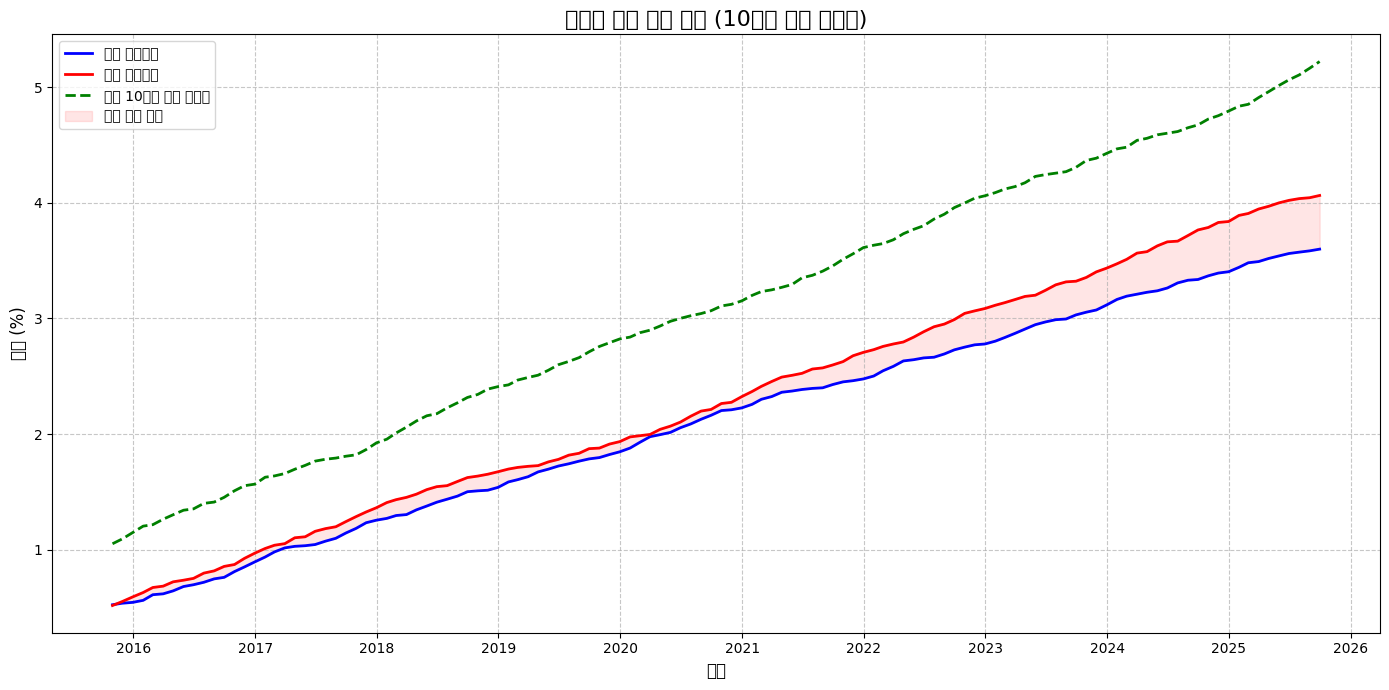

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# --- (이 위에는 FRED, ECOS API 키 설정 및 데이터 로드 함수 코드가 필요합니다) ---

# --- 메인 실행 및 데이터 통합 ---

if __name__ == "__main__":
    
    # ... (생략: FRED, ECOS 데이터 로드 및 rates_df 통합 코드) ...
    
    # 3. 최종 통합 DataFrame 확인 및 정리 (기존 코드 유지)
    rates_df = pd.DataFrame() # 실제 코드에서는 여기에 데이터가 로드된다고 가정

    # --- 데이터 로드 가정을 위한 임시 코드 (실제 실행 시 제거) ---
    # 실제로는 위의 get_fred_data와 get_ecos_data 함수가 실행되어 rates_df에 데이터가 채워져야 합니다.
    # 월별(freq='M')로 10년치 데이터 (120개월)를 생성합니다.
    dates = pd.to_datetime(pd.date_range(start='2015-10-01', periods=120, freq='M'))
    rates_df = pd.DataFrame({
        'US_Base_Rate': np.random.uniform(0.5, 5.5, 120).cumsum() * 0.01 + 0.5,
        'KOR_Base_Rate': np.random.uniform(0.5, 5.0, 120).cumsum() * 0.01 + 0.5,
        'US_10Y_Treasury': np.random.uniform(1.0, 6.0, 120).cumsum() * 0.01 + 1.0,
    }, index=dates)
    rates_df = rates_df.fillna(method='ffill')
    # --- 임시 코드 끝 ---


    if not rates_df.empty:
        print("\n" + "="*50 + "\n")
        print("✅ 금리 시계열 분석 및 시각화 시작 (기간: 10년치, 주기: 월별)")
        
        # 4. 분석 지표 계산 (금리 격차)
        rates_df['KOR_US_Spread'] = rates_df['US_Base_Rate'] - rates_df['KOR_Base_Rate']
        
        # 5. 시각화 (Matplotlib)
        
        plt.figure(figsize=(14, 7))
        
        # 한국 기준금리 (KOR_Base_Rate)
        plt.plot(rates_df.index, rates_df['KOR_Base_Rate'], 
                 label='한국 기준금리', color='blue', linewidth=2)
        
        # 미국 기준금리 (US_Base_Rate)
        plt.plot(rates_df.index, rates_df['US_Base_Rate'], 
                 label='미국 기준금리', color='red', linewidth=2)
        
        # 미국 10년물 국채 수익률 (US_10Y_Treasury)
        plt.plot(rates_df.index, rates_df['US_10Y_Treasury'], 
                 label='미국 10년물 국채 수익률', color='green', linewidth=2, linestyle='--')
        
        # 금리 역전 구간 강조
        plt.fill_between(rates_df.index, rates_df['KOR_Base_Rate'], rates_df['US_Base_Rate'], 
                         where=(rates_df['US_Base_Rate'] > rates_df['KOR_Base_Rate']), 
                         color='red', alpha=0.1, label='한미 금리 역전')
        
        # 제목에 '월별' 강조
        plt.title('주요국 금리 추이 비교 (10년치 월별 시계열)', fontsize=16) 
        plt.xlabel('날짜', fontsize=12)
        plt.ylabel('금리 (%)', fontsize=12)
        plt.legend(fontsize=10, loc='upper left')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show() 
        
    else:
        print("❌ 데이터 로드 실패로 시각화를 진행할 수 없습니다.")

In [1]:
import requests
import os
import json
import pandas as pd

# --- 1. FRED API 설정 (미국 금리) ---
SERIES_IDS = {
    "US_Base_Rate": "FEDFUNDS",         # 실효 연방기금 금리
    "US_10Y_Treasury": "DGS10",          # 10년물 국채 수익률
}
FRED_REQUEST_PARAMS = {
    "observation_start": "2015-10-01",  # 10년치 데이터 요청
    "file_type": "json",
    "frequency": "m"  # 월별 데이터 요청
}

# --- 2. ECOS API 설정 (한국 기준금리) ---
ECOS_REQUEST_PARAMS = {
    "PSTAT_CD": "200Y002", # 주요국 금리 통계표
    "START_TIME": "201510",
    "END_TIME": "202512"
}

# -----------------------------------------------------------------
# 내부 헬퍼 함수들 (파일 내부에서만 사용)
# -----------------------------------------------------------------

def _get_fred_data(series_id, series_name, api_key):
    """(내부 함수) FRED API에서 데이터를 가져옴"""
    base_url = "https://api.stlouisfed.org/fred/series/observations"
    params = FRED_REQUEST_PARAMS.copy()
    params["series_id"] = series_id
    params["api_key"] = api_key # 키를 인자로 받음

    if not api_key:
        print(f"🚨 오류: {series_name} 로드 실패. FRED_API_KEY가 없습니다.")
        return pd.DataFrame()
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()
        data = response.json()
        observations = data.get("observations", [])
        
        df = pd.DataFrame(observations)
        df[series_name] = pd.to_numeric(df['value'], errors='coerce')
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        return df[[series_name]]
    except Exception as e:
        print(f"FRED API 오류 ({series_name}): {e}")
        return pd.DataFrame()

def _get_ecos_data(series_name, item_code, api_key):
    """(내부 함수) ECOS API에서 데이터를 가져옴"""
    if not api_key:
        print(f"🚨 오류: {series_name} 로드 실패. ECOS_API_KEY가 없습니다.")
        return pd.DataFrame()

    ecos_url_base = f"http://ecos.bok.or.kr/api/StatisticSearch/{api_key}/json/kr/1/1000/"
    stat_code = ECOS_REQUEST_PARAMS['PSTAT_CD']
    start = ECOS_REQUEST_PARAMS['START_TIME']
    end = ECOS_REQUEST_PARAMS['END_TIME']
    
    full_url = f"{ecos_url_base}{stat_code}/M/{start}/{end}/{item_code}"

    try:
        response = requests.get(full_url)
        response.raise_for_status()
        data = response.json().get('StatisticSearch', {})
        row_data = data.get('row', [])

        if not row_data:
            print(f"데이터를 찾을 수 없거나 API 키가 유효하지 않습니다. ({series_name})")
            return pd.DataFrame()

        df = pd.DataFrame(row_data)
        df['date'] = pd.to_datetime(df['TIME'], format='%Y%m')
        df.set_index('date', inplace=True)
        df[series_name] = pd.to_numeric(df['DATA_VALUE'], errors='coerce')
        return df[[series_name]]
    except Exception as e:
        print(f"ECOS API 오류 ({series_name}): {e}")
        return pd.DataFrame()

# -----------------------------------------------------------------
# 랩(Lab)에서 호출할 메인 함수 (Public Function)
# -----------------------------------------------------------------

def process_interest_rates(fred_key, ecos_key):
    """
    FRED와 ECOS API에서 금리 데이터를 로드하고 통합/분석하여
    하나의 DataFrame을 반환합니다.
    
    Args:
        fred_key (str): FRED API 키
        ecos_key (str): ECOS API 키
        
    Returns:
        pd.DataFrame: 분석이 완료된 금리 데이터 (실패 시 빈 DataFrame)
    """
    rates_df = pd.DataFrame()
    
    # 1. FRED 데이터 로드 및 통합
    print("\n--- 1. 미국 금리 데이터 (FRED) 로드 및 통합 ---")
    for name, series_id in SERIES_IDS.items():
        df_temp = _get_fred_data(series_id, name, fred_key)
        if not df_temp.empty:
            if rates_df.empty:
                rates_df = df_temp
            else:
                rates_df = rates_df.join(df_temp, how='outer')
                
    # 2. ECOS 데이터 로드 및 통합
    print("\n--- 2. 한국 기준금리 데이터 (ECOS) 로드 및 통합 ---")
    kor_rate_name = "KOR_Base_Rate"
    df_kor = _get_ecos_data(kor_rate_name, "A0010000", ecos_key)
    
    if not df_kor.empty:
        rates_df = rates_df.join(df_kor, how='outer')
    
    if rates_df.empty:
        print("❌ 모든 금리 데이터 로드에 실패했습니다.")
        return pd.DataFrame()
        
    # 3. 데이터 정리 및 분석
    print("\n--- 3. 데이터 정리 및 분석 지표 계산 ---")
    # 금리는 이전 월의 값으로 채움 (정책 변화 시점까지 유지됨)
    rates_df = rates_df.fillna(method='ffill')
    
    # 한미 기준금리 격차 (KOR_US_Spread) 계산
    rates_df['KOR_US_Spread'] = rates_df['US_Base_Rate'] - rates_df['KOR_Base_Rate']
    
    print("✅ 금리 데이터 처리 완료.")
    return rates_df